In [1]:
import pandas as pd
import nilmtk
import matplotlib.pyplot as plt
import random
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import h5py
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from matplotlib import rcParams
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model

In [2]:
redd_data = DataSet('E:\\github\\Nilm\\redd_low.h5')

In [3]:
redd_data.set_window(end="30-4-2011") #Use data only until 4/30/2011
train_elec = redd_data.buildings[1].elec

In [4]:
type(train_elec)

nilmtk.metergroup.MeterGroup

In [5]:
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['fridge'] # The microwave meter that is used as a training target

In [6]:
train_meter

ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])

In [7]:
from RNN import RNNDisaggregator
disaggregator = RNNDisaggregator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 16)             80        
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 256)            148480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,264,977
Trainable params: 1,264,977
Non-trainable params: 0
_________________________________________________________________


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

In [9]:
disaggregator.train(train_mains, train_meter, epochs=5, sample_period=3)
disaggregator.export_model("LStm_s3_fridge1.h5")

4505.783
Epoch 1/5
5573/5573 [==============================] - 132s 21ms/step - loss: 2.1932e-04
Epoch 2/5
5573/5573 [==============================] - 119s 21ms/step - loss: 1.4343e-04
Epoch 3/5
5573/5573 [==============================] - 120s 21ms/step - loss: 1.3478e-04
Epoch 4/5
5573/5573 [==============================] - 119s 21ms/step - loss: 1.3160e-04
Epoch 5/5
5573/5573 [==============================] - 119s 21ms/step - loss: 1.3034e-04


In [11]:
test = DataSet('E:\\github\\Nilm\\redd_low.h5')
test.set_window(start="30-4-2011")
test_elec = test.buildings[1].elec
test_mains = test_elec.mains().all_meters()[0]

In [12]:
disag_filename = 'out_s3_fridge1.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

In [13]:
disaggregator.disaggregate(test_mains,output, train_meter, sample_period=3)

New sensible chunk: 40494
New sensible chunk: 37554
New sensible chunk: 29257
New sensible chunk: 18029
New sensible chunk: 887
New sensible chunk: 11172
New sensible chunk: 46179
New sensible chunk: 10838
New sensible chunk: 9086
New sensible chunk: 11612
New sensible chunk: 33611


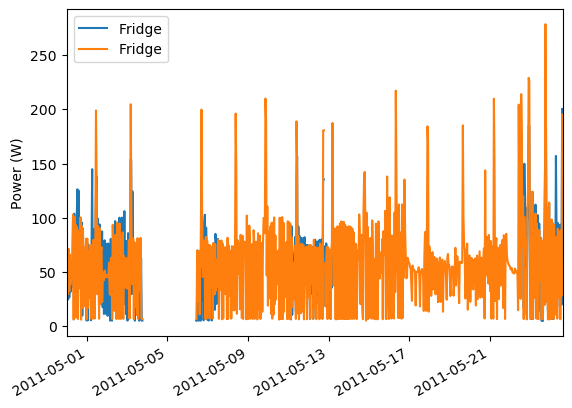

In [14]:
result = DataSet('E:\\github\\Nilm\\RNN\\out_s3_fridge1.h5')
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

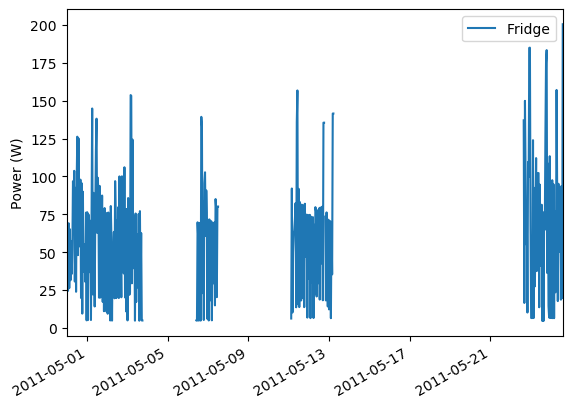

In [15]:
predicted.plot()
plt.show()

In [12]:
from nilmtk.electric import align_two_meters
import numpy as np

def tp_tn_fp_fn(states_pred, states_ground):
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

def recall_precision_accuracy_f1(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    threshold = ground.on_power_threshold()
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        sum_samples += len(chunk)
        pr = np.array([0 if (p)<threshold else 1 for p in chunk.iloc[:,0]])
        gr = np.array([0 if p<threshold else 1 for p in chunk.iloc[:,1]])

        tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)
        p = sum(pr)
        n = len(pr) - p

        chunk_results.append([tp,tn,fp,fn,p,n])

    if sum_samples == 0:
        return None
    else:
        [tp,tn,fp,fn,p,n] = np.sum(chunk_results, axis=0)

        res_recall = recall(tp,fn)
        res_precision = precision(tp,fp)
        res_f1 = f1(res_precision,res_recall)
        res_accuracy = accuracy(tp,tn,p,n)

        return (res_recall,res_precision,res_accuracy,res_f1)

def relative_error_total_energy(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        E_pred = sum(chunk.iloc[:,0])
        E_ground = sum(chunk.iloc[:,1])

        chunk_results.append([
                            E_pred,
                            E_ground
                            ])
    if sum_samples == 0:
        return None
    else:
        [E_pred, E_ground] = np.sum(chunk_results,axis=0)
        return abs(E_pred - E_ground) / float(max(E_pred,E_ground))

def mean_absolute_error(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    total_sum = 0.0
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        total_sum += sum(abs((chunk.iloc[:,0]) - chunk.iloc[:,1]))
    if sum_samples == 0:
        return None
    else:
        return total_sum / sum_samples


def recall(tp,fn):
    return tp/float(tp+fn)

def precision(tp,fp):
    return tp/float(tp+fp)

def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)

def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)


In [16]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

============ Recall: 0.7668438360354849
============ Precision: 0.5850545539413035
============ Accuracy: 0.6731762823219103
============ F1 Score: 0.6637266258480887
============ Relative error in total energy: 0.2583151712534099
============ Mean absolute error(in Watts): 22.976693577836617
